In [1]:
import sys
from pathlib import Path, PureWindowsPath
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-3]) #remonter au dossier root du projet
os.chdir(path_root)
print(os.getcwd())
sys.path.append(os.getcwd() + "/sources/classification/")

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from gensim.utils import tokenize
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from pathlib import Path, PureWindowsPath
from lib_classification import *
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [3]:
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

1    1833
0    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"> Si la Bienheureuse Vierge avait été sanctifiée, de quelque manière que ce > fût, avant son animation, elle n’aurait jamais encouru la tache de la faute > originelle. Ainsi elle n’aurait pas eu besoin de la rédemption et du salut > apportés par le Christ, dont il est dit en S. Matthieu (1, 21) : « Il > sauvera son peuple de ses péchés. » Or il est inadmissible que le Christ ne > soit pas » le sauveur de tous les hommes » (1 Tm 4, 10). Il reste donc que > la sanctification de la Bienheureuse Vierge Marie s’est accomplie après son > animation.",si bienheureux vierge sanctifiée quelque manière avant animation jamais encouru tache faute originelle ainsi besoin rédemption salut apportés christ dont dit matthieu « sauvera peuple péché » or inadmissible christ » sauveur tous homme » tm reste donc sanctification bienheureux vierge marie accomplie après animation,philosophy,548,1
1,1,[Kline on the Works Principle in the Mosaic economy – Lee Irons](http://www.upper-register.com/papers/works-principle-mosaic- economy.pdf),kline the works principle in the mosaic economy – lee ironshttpwwwupper-registercompapersworks-principle-mosaic- economypdf,baptism,138,0
...,...,...,...,...,...,...
3664,3664,En langage thomiste on dira: « Dieu n’est pas une composition de genre et de différence ».,langage thomiste dira « dieu composition genre différence »,philosophy,90,1
3665,3665,"Vous qui êtes en médecine, vous devriez savoir, que c’est en moyenne (c’est une moyenne, pour certains avant, et pour d’autres après. Comme pour tout nous sommes différents) à partir de 7 ans que l’enfant commence à faire la différence entre le bien et le mal. Qu’il commence à reconnaître dans ses actions, paroles, grâce à la réponse que l’autre lui donne si ce qu’il fait, ou dit est bien ou mal. Avant cela il n’en avait aucunes conscience.",médecine devriez savoir moyenne cest moyenne certain avant autres après comme tout différent partir an enfant commence faire différence entre bien mal commence reconnaître action parole grâce réponse autre donne si fait dit bien mal avant cela aucunes conscience,baptism,444,0


In [4]:
tokens = corpus["message_preprocessed"].apply(word_tokenize)
model_skip_gram = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=0) #modele cbow
model = model_skip_gram

Utilisation des features word2vec pour la classification

Creation features du modele : moyenne des "mots" d'une phrase

In [5]:
words_vectors_skip_gram = model_skip_gram.wv
vocab = model_skip_gram.wv.index_to_key
corpus_average_vectors = []
sentence_average_vector = []
sentence_vectors = []
vector_space_dim = 200

for i in range(len(tokens)):
    sentence = tokens[i]
    sentence_words = list(set(vocab) & set(sentence))
    if(sentence_words != []):
        sentence_average_vector = np.mean(words_vectors_skip_gram[sentence_words], axis=0)
        # print("words_vectors_skip_gram[sentence_words] =", words_vectors_skip_gram[sentence_words])
    else:
        print("sentence =", sentence)
        print("sentence_words =", sentence_words)
        sentence_average_vector = np.zeros(vector_space_dim)
    corpus_average_vectors.append(sentence_average_vector)
# print("len(sentence_vectors) =", len(sentence_vectors))
# print("sentence_vectors =", sentence_vectors)
# print("len(sentence_average_vector) =", len(sentence_average_vector))
# len(corpus_average_vectors)
corpus_word2vec_sk = pd.DataFrame(corpus_average_vectors)
corpus_word2vec_sk['id'] = corpus['id']
corpus_word2vec_sk['message'] = corpus['message']
corpus_word2vec_sk["category_bin"] = corpus["category_bin"]
# corpus_word2vec_sk

sentence = ['tortarolohttpssecuregravatarcomavatarbaddffbdfaefbsdmmrg']
sentence_words = []


In [6]:
X = corpus_word2vec_sk.iloc[:, np.r_[0:200]]
y = corpus_word2vec_sk["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

In [7]:
# Cross validation avec fonction automatisee
# Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVC (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'f1_macro']
scoring = ['accuracy', 'f1_macro']
num_iter = 2
k = 10
do_cross_validation(X_train, y_train, scoring, num_iter, k)

[('test_accuracy', 0.5102), ('test_f1_macro', 0.3378)] (LR)
[('test_accuracy', 0.7423), ('test_f1_macro', 0.7419)] (AdaBoostClassifier)
[('test_accuracy', 0.6565), ('test_f1_macro', 0.6248)] (KNN)
[('test_accuracy', 0.8001), ('test_f1_macro', 0.7997)] (RandomForest)
[('test_accuracy', 0.5024), ('test_f1_macro', 0.3381)] (SGDClassifier)
[('test_accuracy', 0.8571), ('test_f1_macro', 0.8569)] (SVM)
[('test_accuracy', 0.6494), ('test_f1_macro', 0.649)] (DecisionTreeClassifier)


c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:111: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:112: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


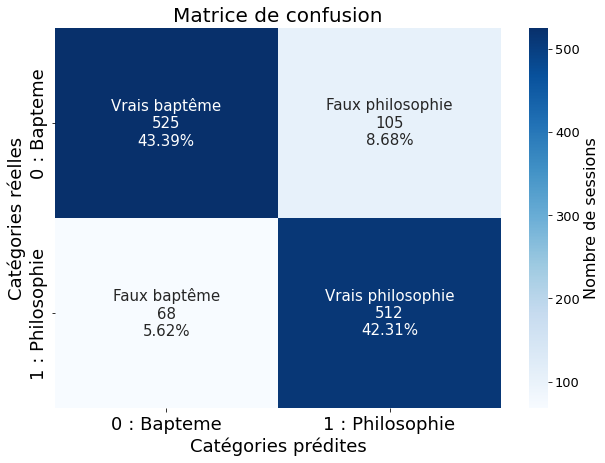

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# model_cbow
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_confusion_matrix(y_test, y_pred, model)

In [9]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       630
           1       0.83      0.88      0.86       580

    accuracy                           0.86      1210
   macro avg       0.86      0.86      0.86      1210
weighted avg       0.86      0.86      0.86      1210



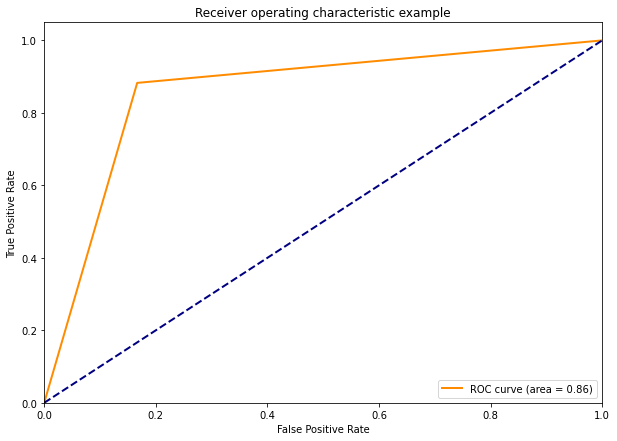

In [10]:
# Courbe ROC et AUC
plot_roc(y_test, y_pred)

sources :
http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html

In [11]:
k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

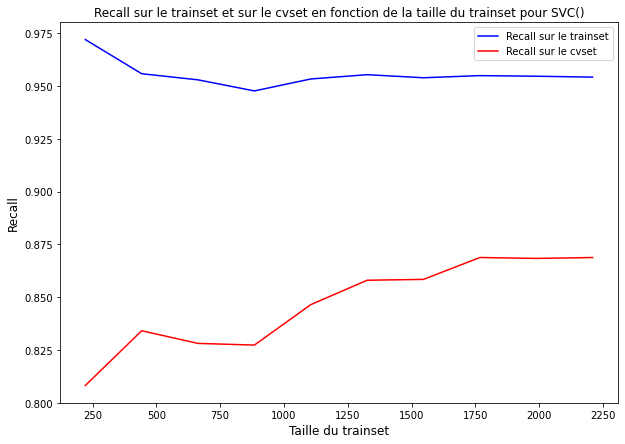

In [12]:
model = SVC() #le meilleur modele garde apres cross validation 
get_learning_curve(model, X_train, y_train, cv_param, "recall", train_sizes, n_jobs)

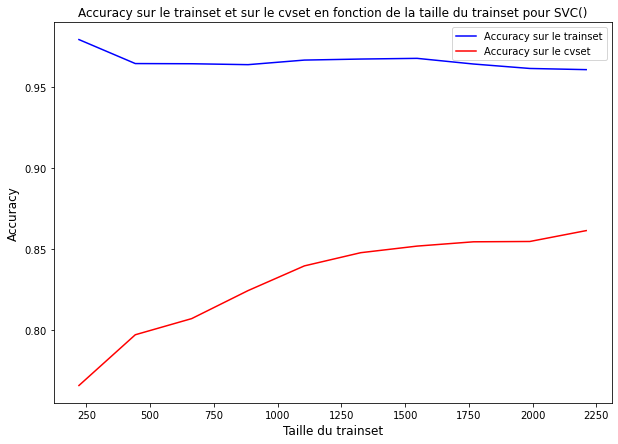

In [13]:
get_learning_curve(model, X_train, y_train, cv_param, "accuracy", train_sizes, n_jobs)

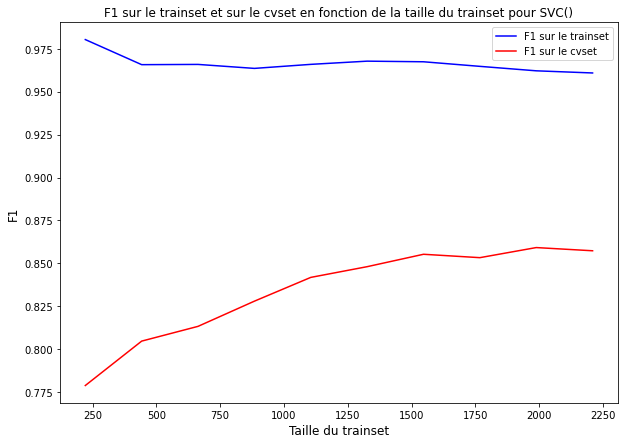

In [14]:
get_learning_curve(model, X_train, y_train, cv_param, "f1", train_sizes, n_jobs)

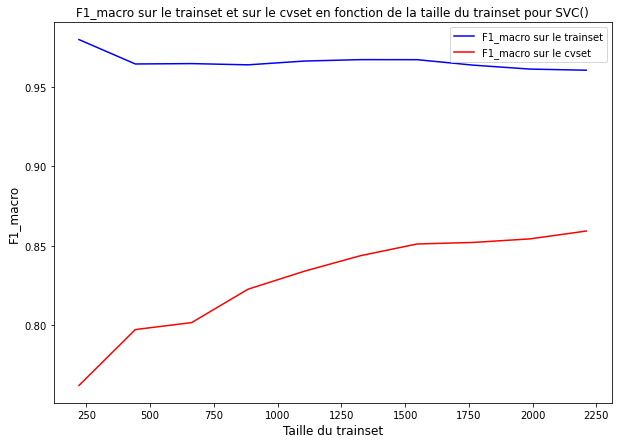

In [15]:
get_learning_curve(model, X_train, y_train, cv_param, "f1_macro", train_sizes, n_jobs)

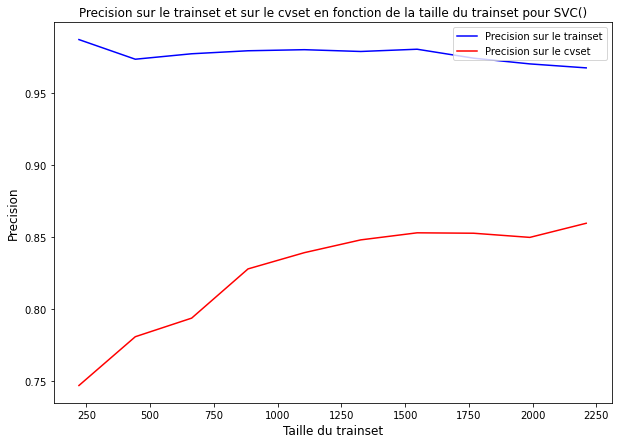

In [16]:
get_learning_curve(model, X_train, y_train, cv_param, "precision", train_sizes, n_jobs)

In [17]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1210, 4)
(173, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [18]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) 

,id,message,message_preprocessed,category,length,category_bin
3187,3187,"Réfléchissons à cela : va-t-on dire à son enfant qu’il doit pardonner son frère car c’est bien ou qu’il doit le pardonner « comme Dieu l’a pardonné en Christ » (Col 3:13) ? Peut-on prier _avec_ nos enfants « _Notre_ Père qui es aux cieux… » ? Si Dieu est leur Père, ne sont-ils pas ses enfants ?",réfléchissons cela va-t-on dire enfant doit pardonner frère car bien doit pardonner « comme dieu a pardonné christ » col peut-on prier enfant « père cieux… » si dieu père sont-ils enfant,baptism,295,0
1657,1657,"Le baptême ne peut être administré que par un pasteur ou quelqu’un qui en a une commission. Dès le seizième siècle, le baptême administré par celui qui n’a aucune vocation ni commission est considéré comme nul. Dans le contexte d’alors, cela signifiait que l’on acceptait les baptêmes faits par des prêtres catholiques, mais qu’on rejetait ceux qui étaient faits par des moines, des proposants [élèves pasteurs] ou simples particuliers. Détail amusant : la plupart des gens au début du dix-septième siècle arrivaient jusqu’à la vieillesse sans autre baptême que celui qui était fait par les sages-femmes, considéré comme nul, ce qui a posé un problème particulier au synode de la Rochelle 1607. Par ailleurs, il ne suffit pas d’être docteur: c’est bien le statut de pasteur qui permet d’administrer les sacrements, et celui-là seul.",baptême peut être administré pasteur a commission dès seizième siècle baptême administré celui a aucune vocation ni commission considéré comme nul contexte alors cela signifiait acceptait baptême fait prêtre catholique rejetait ceux fait moine proposant élève pasteur simple particulier détail amusant plupart gens début dix-septième siècle arrivaient vieillesse sans autre baptême celui fait sage-femme considéré comme nul a posé problème particulier synode rochelle ailleurs suffit être docteur bien statut pasteur permet administrer sacrement celui-là seul,baptism,832,0
2496,2496,"Après avoir examiné les données, et à la lumière des récentes études, il semble que nous n’ayons pas suffisamment de preuves pour affirmer que le baptême du prosélyte a façonné les présupposés juifs concernant l’initiation des enfants à l’époque de l’Église apostolique, ou pour savoir avec confiance comment il aurait façonné ces présupposés si on l’avait fait à ce moment. La circoncision et la participation des enfants à la vie religieuse juive sont donc probablement nos indicateurs les plus fiables des attentes des juifs concernant l’initiation des enfants au premier siècle.",après avoir examiné donnée lumière récentes étude semble suffisamment preuve affirmer baptême prosélyte a façonné présupposé juif concernant initiation enfant époque église apostolique savoir confiance comment façonné présupposé si fait moment circoncision participation enfant vie religieux juif donc probablement indicateur plus fiables attente juif concernant initiation enfant premier siècle,baptism,582,0
1626,1626,"Ainsi, le baptême est une réalité qui peut être toujours à nouveau saisie par la foi. La prédication, c’est l’Évangile prêché aux oreilles, le baptême c’est l’Évangile scellé devant nos yeux.",ainsi baptême réalité peut être toujours nouveau saisie foi prédication évangile prêché oreille baptême évangile scellé devant yeux,baptism,191,0
599,599,"Au lieu de chercher à justifier des actes, traditions déjà bien encrées en toi, cherchent plutôt la vérité en Dieu.",lieu chercher justifier acte tradition déjà bien encrées cherchent plutôt vérité dieu,baptism,115,0
3469,3469,### #3 Paul n’a pas utilisé le pédobaptême comme argument apologétique.,paul a utilisé pédobaptême comme argument apologétique,baptism,71,0
408,408,Ne sous-estimons pas ces points communs si précieux mais servons-nous en comme base dans nos débats et défendons-les ensemble puisqu’il s’agit de vérités fondamentales.,sous-estimons point commun si précieux servons-nous comme base débat défendons-les ensemble agit vérit

In [19]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id])

,id,message,message_preprocessed,category,length,category_bin
2498,2498,"Le style d’écriture de Van Til et son utilisation idiosyncrasique d’une terminologie philosophique obscure ne sont pas les seuls obstacles faisant face à une évaluation attentive et critique de sa pensée. D’autres obstacles sont apparus en raison du débat qui perdure sur l’enseignement de Van Til. Certains Van Tilliens, par exemple, pensent que les critiques de Van Til n’ont jamais vraiment compris Van Til. John Frame, par exemple, dit que les critiques de Van Til « semblent toujours passer à côté de ce qui est évident6. » Cela est vrai dans une certaine mesure, et signifie que les défenseurs de la pensée de Van Til ont dû passer beaucoup de temps à corriger des interprétations erronées7.",style écriture van til utilisation idiosyncrasique terminologie philosophique obscure seuls obstacle faisant face évaluation attentive critique pensée autres obstacle apparus raison débat perdure enseignement van til certain van tilliens exemple pensent critique van til jamais vraiment compris van til john frame exemple dit critique van til « semblent toujours passer côté évident » cela vrai certaine mesure signifie défenseur pensée van til dû passer beaucoup temps corriger interprétation erronées,philosophy,697,1
1825,1825,"L’une des caractéristiques de la Scolastique réformée est l’utilisation de distinctions. Les Réformés ont hérité de cette méthode théologique du Moyen Âge. Les catholiques romains, les luthériens et les théologiens remonstrants ont également utilisé des distinctions pour présenter leur propre théologie. Des mots et des termes ambigus se retrouvent souvent dans le discours théologique, ce qui nécessite l’utilisation de distinctions pour aider à clarifier précisément ce que l’on veut dire.",lune caractéristique scolastique réformée utilisation distinction réformé hérité cette méthode théologique moyen âge catholique romain luthérien théologien remonstrants également utilisé distinction présenter propre théologie mot terme ambigu retrouvent souvent discours théologique nécessite utilisation distinction aider clarifier précisément veut dire,philosophy,492,1
1395,1395,"Thomas précise alors que l’amour qui se trouve en Dieu n’est pas un amour _sensitif_ comme le jour où je suis tombé amoureux de ma femme, mais un amour _intellectuel_. Avant de monter sur vos grands chevaux écoutez ce que signifient les deux pour la théologie médiévale.",thomas précise alors amour trouve dieu amour sensitif comme jour où tombé amoureux femme amour intellectuel avant monter grand chevau écoutez signifient deux théologie médiévale,philosophy,270,1
2823,2823,"> Les événements de l’Ancien Testament préfigurent le Nouveau selon la 1ère > épître aux Corinthiens (10, 11) : « Cela leur arrivait en figure. » Mais le > Psaume (47, 5) dit que » le Très-Haut a sanctifié son tabernacle » et cela > paraît symboliser la sanctification de la Mère de Dieu, selon un autre > Psaume (19, 6) : « Il a établi son tabernacle dans le soleil », et l’Exode > (40, 31) dit au sujet de ce tabernacle : « Lorsque tout fut terminé, la nuée > recouvrit le tabernacle du Témoignage, et la gloire du Seigneur le remplit. > » De même, la Bienheureuse Vierge n’a été sanctifiée qu’après l’achèvement > de tout son être, corps et âme.",événement ancien testament préfigurent nouveau selon ère épître corinthiens « cela arrivait figure » psaume dit » très-haut a sanctifié tabernacle » cela paraît symboliser sanctification mère dieu selon autre psaume « a établi tabernacle soleil » exode dit sujet tabernacle « lorsque tout terminé nuée recouvrit tabernacle témoignage gloire seigneur remplit » bienheureux vierge a sanctifiée après achèvement tout être corps âme,philosophy,648,1
718,718,"Vivre est d’abord et avant tout une façon d’être particulière. Vous n’êtes pas vivant par ce que vous faites, vous êtes vivants par ce que vous êtes. C’est votre nature, le quoi-vous-êtes qui fait que vous êtes vivants.",vivre abord avan